In [8]:
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

from copy import deepcopy
import pandas as pd
from utils import train_fairness_classifiers
from src.analyze_metric_sensitivity import analyze_metric_sensitivity, get_metric_fn
from src.data_utils import joint_distribution

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [10]:
ds = np.load("../data/dutch.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]
perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [4]:
classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric="DP")
df = pd.DataFrame({
    "A": A_test, "Y": y_test, "P": classifiers[0].predict(X_test)
})
prob_df = joint_distribution(df, ["A", "Y", "P"])

/Users/njwfish/fragile.ml/.conda/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/njwfish/fragile.ml/.conda/lib/python3.11

In [5]:
import json
with open("../src/bias_configs/selection.json", "r") as f:
    selection_config = json.load(f)

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


Text(0, 0.5, 'Metric Value')

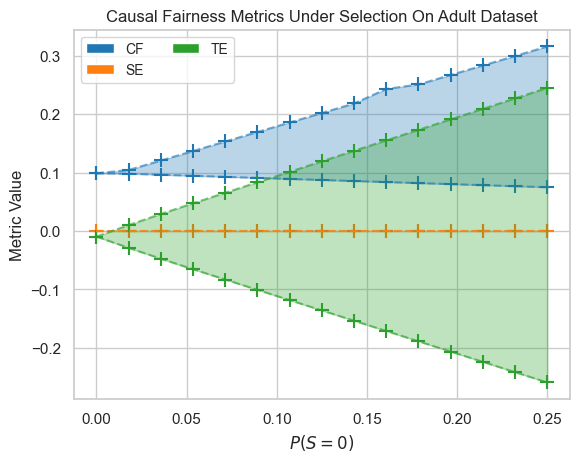

In [11]:
metrics = ["CF", "SE", "TE"]
colours = sns.color_palette("tab10", 3)

fig, ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize= (25.6/4,4.8 ))

cf = 0.1

range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.25,15)
for i, metric in enumerate(metrics):
    lower_results = []
    upper_results = []
    for val in range_ab:
        cfg = deepcopy(selection_config)
        if metric == "CF":
           cfg["constraints"].append(f"P(P(A=1)=1&P(A=0)=1&S=1) + P(P(A=1)=0&P(A=0)=0&S=1) == {cf} * P(S=1)")

        sens_results = analyze_metric_sensitivity(
            prob_df.copy(), get_metric_fn(metric), sensitivity_parameter_values=val, **cfg
        )
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
    ax.fill_between(range_ab, lower_results, upper_results, alpha=.3,color = colours[i])
    ax.plot(range_ab, upper_results, ls='--', alpha=.6,color=colours[i])
    ax.plot(range_ab, lower_results, ls='--', alpha=.6,color=colours[i])
    ax.scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax.scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])

legend_elements = [
    Patch(facecolor=colours[0], label='Color Patch'),
    Patch(facecolor=colours[1], label='Color Patch'),
    Patch(facecolor=colours[2], label='Color Patch'),
]
legend_titles = metrics 
leg = ax.legend(legend_elements,legend_titles,loc="upper left",ncol=2,fontsize ="10")
ax.set_title("Causal Fairness Metrics Under Selection On Adult Dataset")
ax.set_xlabel(r"$P(S=0)$")
ax.set_ylabel("Metric Value")